# Building Production Machine Learning Using SageMaker

This notebook creates a [SageMaker Pipeline](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html) to build an end-to-end Machine Learning system to solve the problem of classifying penguin species. With a SageMaker Pipeline, you can create, automate, and manage end-to-end Machine Learning workflows at scale.

You can find more information about Amazon SageMaker in the [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html). The [AWS Machine Learning Blog](https://aws.amazon.com/blogs/machine-learning/) is an excellent source to stay up-to-date with SageMaker.

This example uses the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data), the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) library, and the [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/). 

<img src='https://imgur.com/orZWHly.png' alt='Penguins dataset' width="800">

## Table of Contents

1. [Session 1 - Production Machine Learning is Different](#Session-1---Production-Machine-Learning-is-Different) 
2. [Session 2 - Implementing a Production Pipeline](#Session-2---Implementing-a-Production-Pipeline)
3. [Session 3 - Building a Model](#Session-3---Building-a-Model)
4. [Session 4 - Evaluating and Registering The Model](#Session-4---Evaluating-and-Registering-The-Model)
5. [Session 5 - Deploying The Model](#Session-5---Deploying-The-Model)
6. [Session 6 - Monitoring](#Session-6---Monitoring)
7. [Running the Pipeline](#Running-the-Pipeline)

This notebook is part of the [Machine Learning School](https://www.ml.school) program.

You can run this notebook in **Local Mode** or in **SageMaker Studio**. If you are running this notebook in Local Mode, you need to set up your environment running the [Local Setup Notebook](local-setup.ipynb). If you are running this notebook in SageMaker Studio, you need to set up your environment running the [Studio Setup Notebook](studio-setup.ipynb) and ensure your kernel is "TensorFlow 2.11 Python 3.9 CPU Optimized" with the start-up script named "packages."

<div class="alert" style="background-color:#6e420c; color: #fff"><strong>Note:</strong> 
    Select a unique name for your <strong>BUCKET</strong>. Change the default value of the `BUCKET` constant below.
</div>

In [60]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import logging
import sagemaker
import ipytest
import boto3
from pathlib import Path

from sagemaker.workflow.steps import CacheConfig
from sagemaker.workflow.pipeline_context import PipelineSession, LocalPipelineSession

# Update this variable to your bucket name. This name must be unique
# across all AWS accounts.
BUCKET = "mlschool"

# To run this notebook in Local Model, this constant must be set to True.
# I'm trying to do this automatically by checking for a specific environment
# variable that is set by SageMaker when you run the notebook inside SageMaker
# Studio. 
LOCAL_MODE = "SAGEMAKER_INTERNAL_IMAGE_URI" not in os.environ

# If you are running this notebook on an ARM64 machine, you will need
# to build a custom Docker image using the setup notebook. This is
# because SageMaker doesn't provide a TensorFlow image that supports 
# The Apple M chips.
architecture = !(uname -m)
IS_APPLE_M_CHIP = architecture[0] == "arm64"

# This is a dummy role that will be ignored when we run the
# pipeline in Local Mode.
DUMMY_ROLE = "arn:aws:iam::111111111111:role/service-role/AmazonSageMaker-ExecutionRole-11111111111111"


CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(parents=True, exist_ok=True)
INFERENCE_CODE_FOLDER = CODE_FOLDER / "inference"
INFERENCE_CODE_FOLDER.mkdir(parents=True, exist_ok=True)

sys.path.append(f"./{CODE_FOLDER}")
sys.path.append(f"./{INFERENCE_CODE_FOLDER}")

ipytest.autoconfig(raise_on_error=True)

# We'll use these two variables to configure the steps that do not support
# Local Mode.
pipeline_session = PipelineSession(default_bucket=BUCKET) if not LOCAL_MODE else None
execution_role = sagemaker.get_execution_role() if not LOCAL_MODE else DUMMY_ROLE

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(),
        "instance_type": "local",
        "role": DUMMY_ROLE,

        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": "sagemaker-tensorflow-training-toolkit-local" if IS_APPLE_M_CHIP else None,
        "framework_version": None if IS_APPLE_M_CHIP else "2.8",
        "py_version": None if IS_APPLE_M_CHIP else "py38",
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "role": execution_role,
        "image": None,        
        "framework_version": "2.11",
        "py_version": "py39",
    }

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)


sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

# We'll use this variable to specify the cache configuration for
# the pipeline steps that support it.
cache_config = CacheConfig(enable_caching=True, expire_after="15d")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Session 1 - Production Machine Learning is Different

In this session we'll run Exploratory Data Analysis on the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) and we'll build a simple [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with one step to split and transform the data. We'll use a [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for the transformations, and a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to execute a preprocessing script. Check the [SageMaker Pipelines Overview](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) for an introduction to the fundamental components of a SageMaker Pipeline.

## Step 1 - Exploratory Data Analysis

Let's run Exploratory Data Analysis on the dataset. The goal of this section is to understand the data and the problem we are trying to solve.

The first step is to create an S3 bucket where we will store the data and every resource we are going to create.

In [61]:
BUCKET = "mlschool"

!aws s3api create-bucket --bucket $BUCKET

# If you want to create a bucket in a region other than us-east-1, you need to
# use the "--create-bucket-configuration" argument when creating the bucket. 
# For example, if you want to create a bucket in the eu-west-1 region, you can
# uncomment the following line of code:

# !aws s3api create-bucket --bucket $BUCKET --create-bucket-configuration LocationConstraint="eu-west-1"

{
    "Location": "/mlschool"
}


After we have a bucket, we can download the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) and store it in the bucket.

In [62]:
import pandas as pd
import numpy as np
import urllib.request
from sagemaker.s3 import S3Uploader


S3_LOCATION = f"s3://{BUCKET}/penguins"
DATA_FILEPATH = CODE_FOLDER / "data.csv"

urllib.request.urlretrieve(
    "https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins_size.csv", 
    DATA_FILEPATH
)

S3Uploader.upload(local_path=str(DATA_FILEPATH), desired_s3_uri=f"{S3_LOCATION}/data")

's3://mlschool/penguins/data/data.csv'

Let's load the Penguins dataset. The dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin

In [63]:
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Now, let's get the summary statistics for the features in our dataset.

In [64]:
penguins.describe(include='all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


The distribution of the categories in our dataset are:

- `species`: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
- `island`: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
- `sex`: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender ('.').

In [65]:
species_distribution = penguins['species'].value_counts()
island_distribution = penguins['island'].value_counts()
sex_distribution = penguins['sex'].value_counts()

print(species_distribution)
print()
print(island_distribution)
print()
print(sex_distribution)

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64


Let's replace the ambiguous value in the `sex` column with a null value.

In [66]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)
penguins["sex"].value_counts()

MALE      168
FEMALE    165
Name: sex, dtype: int64

Next, let's check for any missing values in the dataset.

In [67]:
penguins.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's get rid of the missing values. For now, we are going to replace the missing values with the most frequent value in the column. Later, we'll use a different strategy to replace missing numeric values.

In [68]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:,:] = imputer.fit_transform(penguins)
penguins.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Let's visualize the distribution of categorical features.

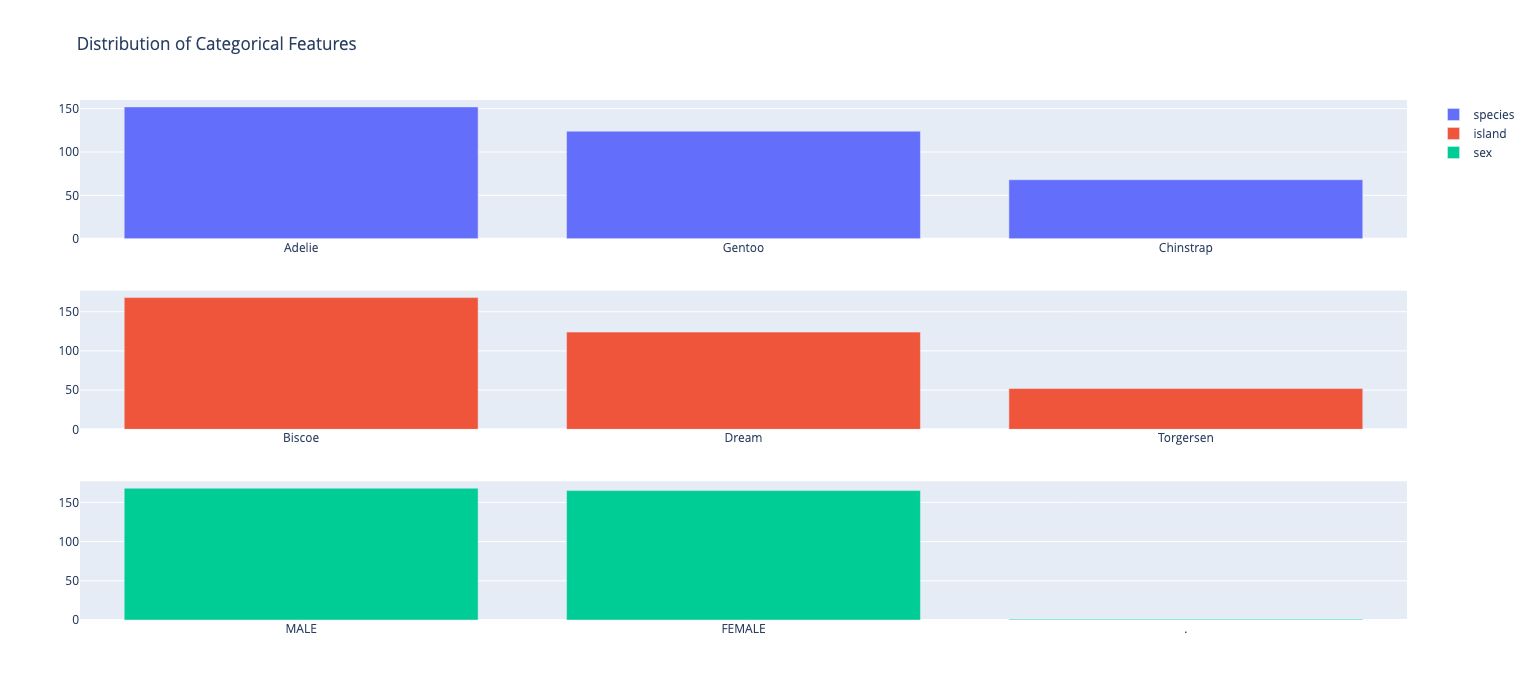

In [69]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Bar(x=species_distribution.index, y=species_distribution.values, name='species'), row=1, col=1)
fig.add_trace(go.Bar(x=island_distribution.index, y=island_distribution.values, name='island'), row=2, col=1)
fig.add_trace(go.Bar(x=sex_distribution.index, y=sex_distribution.values, name='sex'), row=3, col=1)

fig.update_layout(height=700, width=960, title_text="Distribution of Categorical Features")
fig.show()

Let's visualize the distribution of numerical columns.

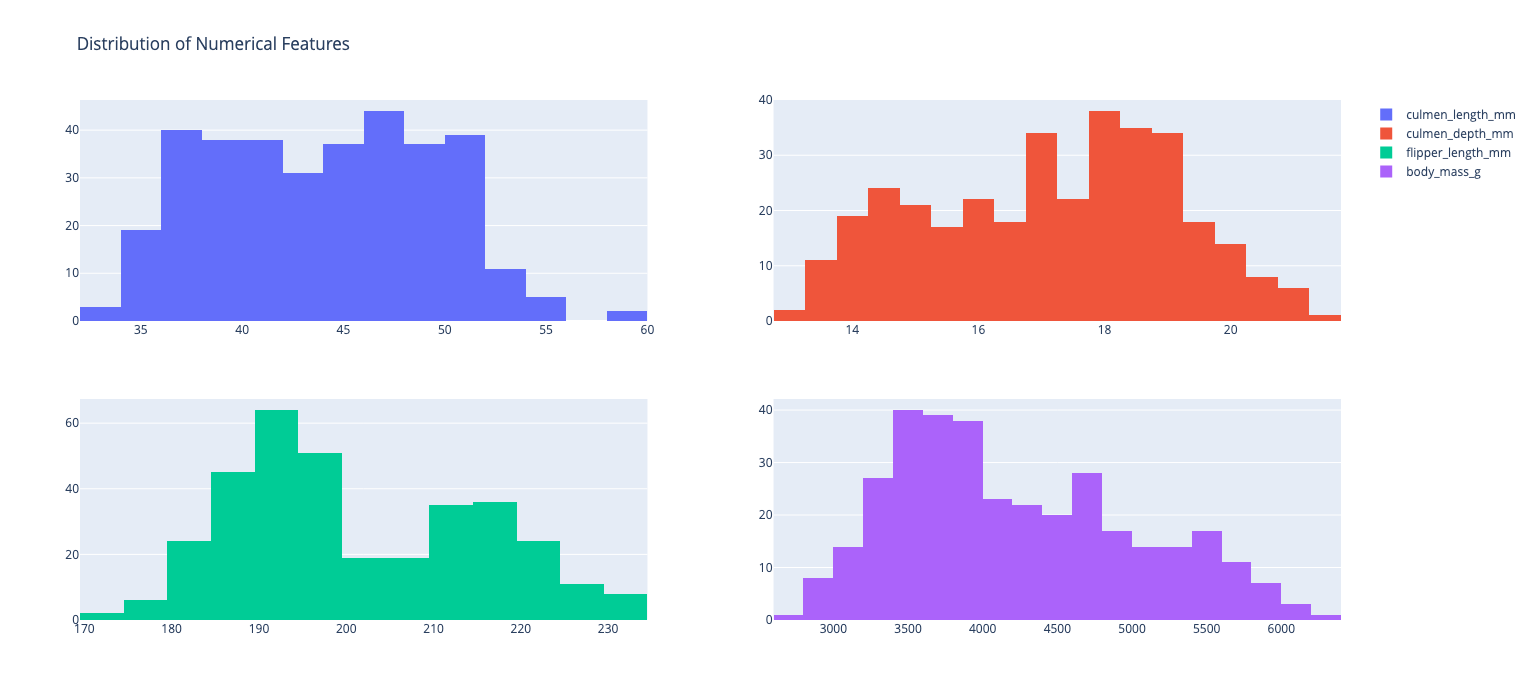

In [70]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Histogram(x=penguins['culmen_length_mm'], name='culmen_length_mm', nbinsx=20), row=1, col=1)
fig.add_trace(go.Histogram(x=penguins['culmen_depth_mm'], name='culmen_depth_mm', nbinsx=20), row=1, col=2)
fig.add_trace(go.Histogram(x=penguins['flipper_length_mm'], name='flipper_length_mm', nbinsx=20), row=2, col=1)
fig.add_trace(go.Histogram(x=penguins['body_mass_g'], name='body_mass_g', nbinsx=20), row=2, col=2)
fig.update_layout(height=700, width=960, title_text="Distribution of Numerical Features")

fig.show()

Let's display a scatter matrix with every numeric feature from our dataset.

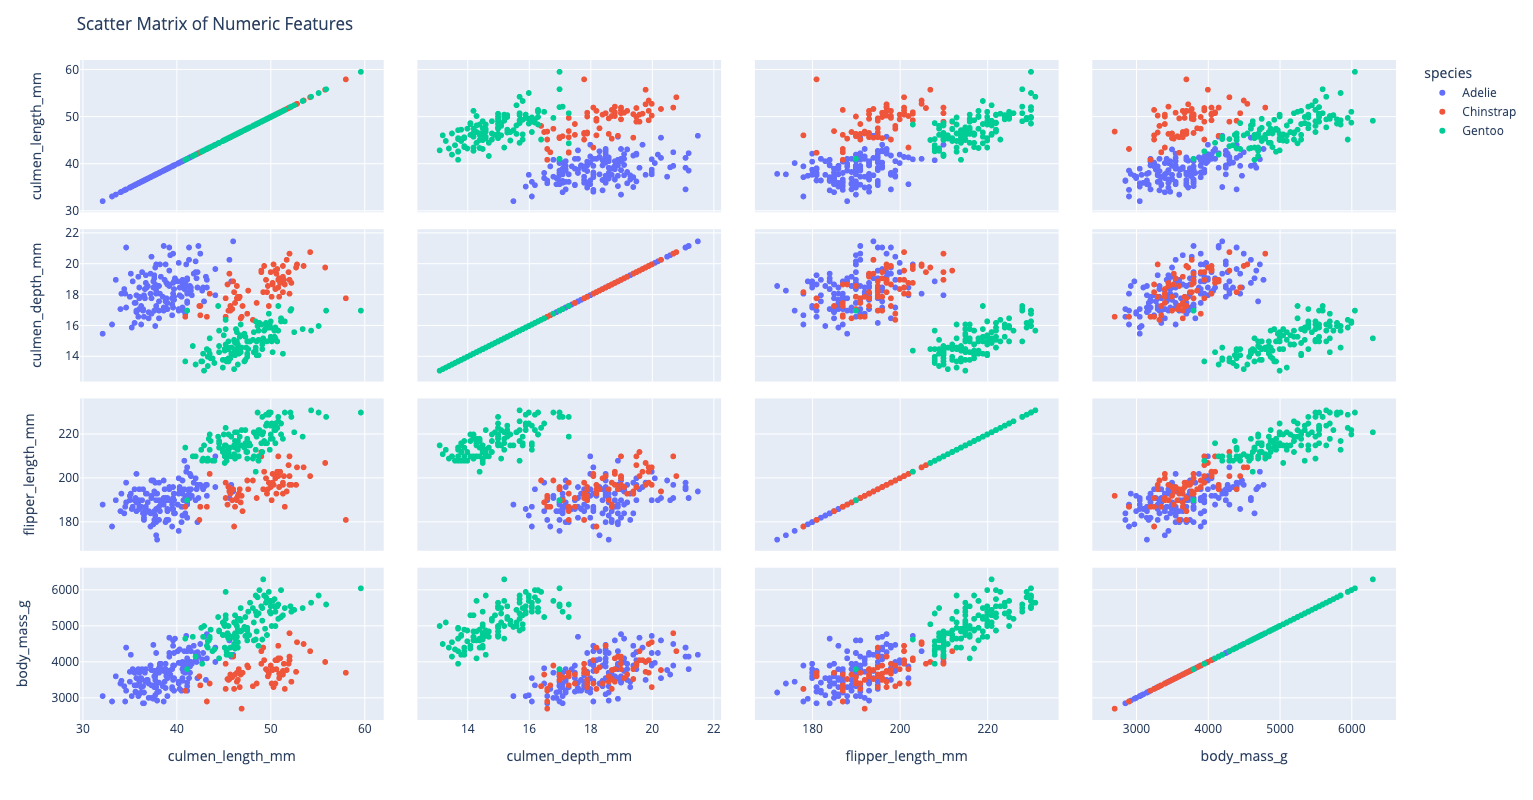

In [71]:
fig = px.scatter_matrix(
    penguins, 
    dimensions=["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"], 
    color="species")

fig.update_layout(height=800, width=960, title_text="Scatter Matrix of Numeric Features")

fig.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

Here are three examples of what we get from interpreting the covariance matrix below:

1. Penguins that weight more tend to have a larger culmen.
2. The more a penguin weights, the shallower its culmen tends to be.
3. There's a small variance between the culmen depth of penguins.

In [72]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables.

Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have larger flippers.
2. Penguins with a shallower culmen tend to have larger flippers.
3. The length and depth of the culmen have a slight negative correlation.

In [73]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Let's display the distribution of species by island.

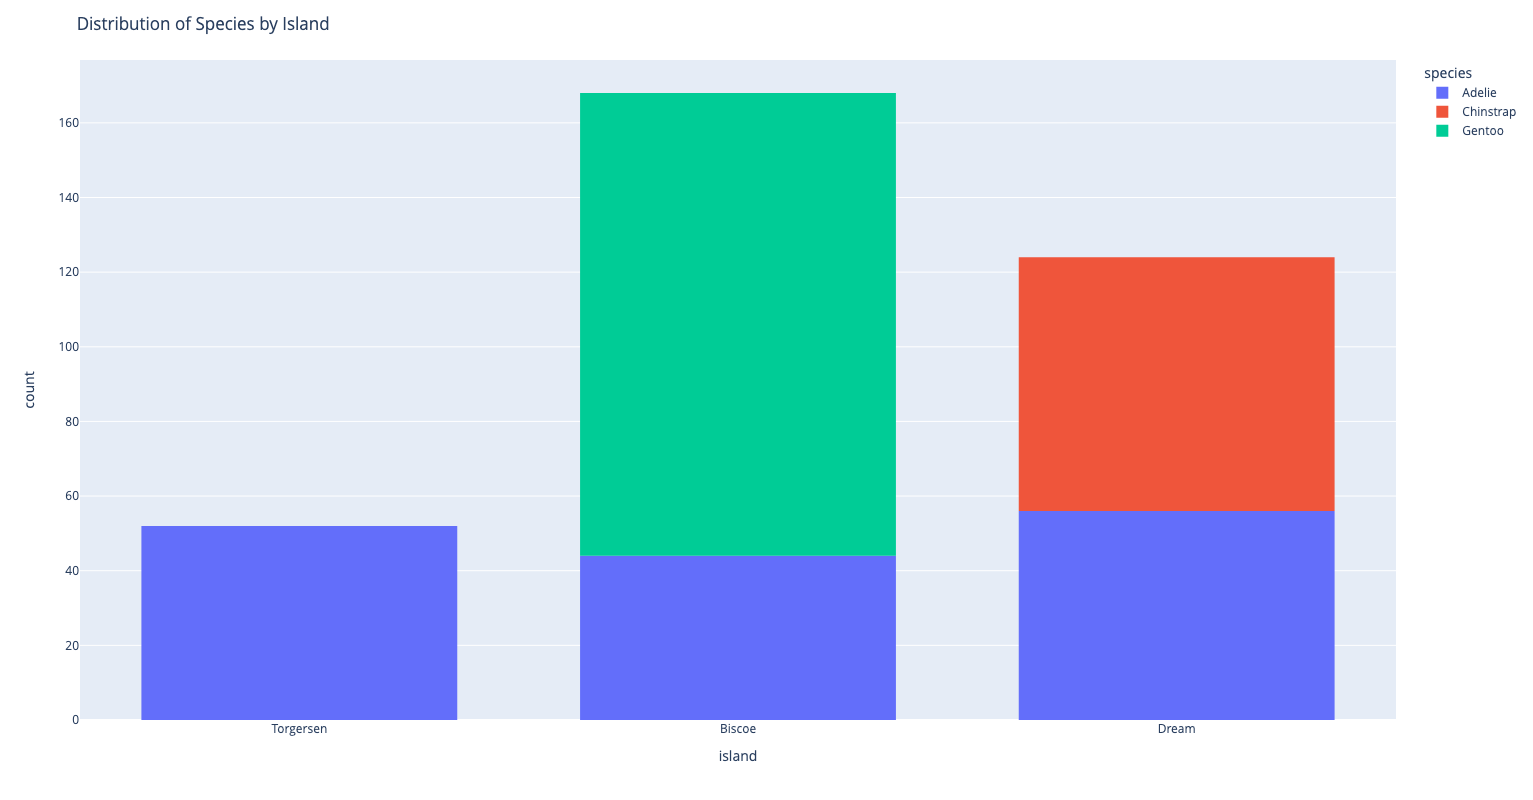

In [74]:
fig = px.histogram(penguins, x="island", color="species", nbins=50)

fig.update_layout(
    height=800, 
    width=960, 
    title_text="Distribution of Species by Island",
    xaxis_title_text='island',
    yaxis_title_text='count',
    bargap=0.2,
    bargroupgap=0.1
)

fig.show()

Let's display the distribution of species by sex.

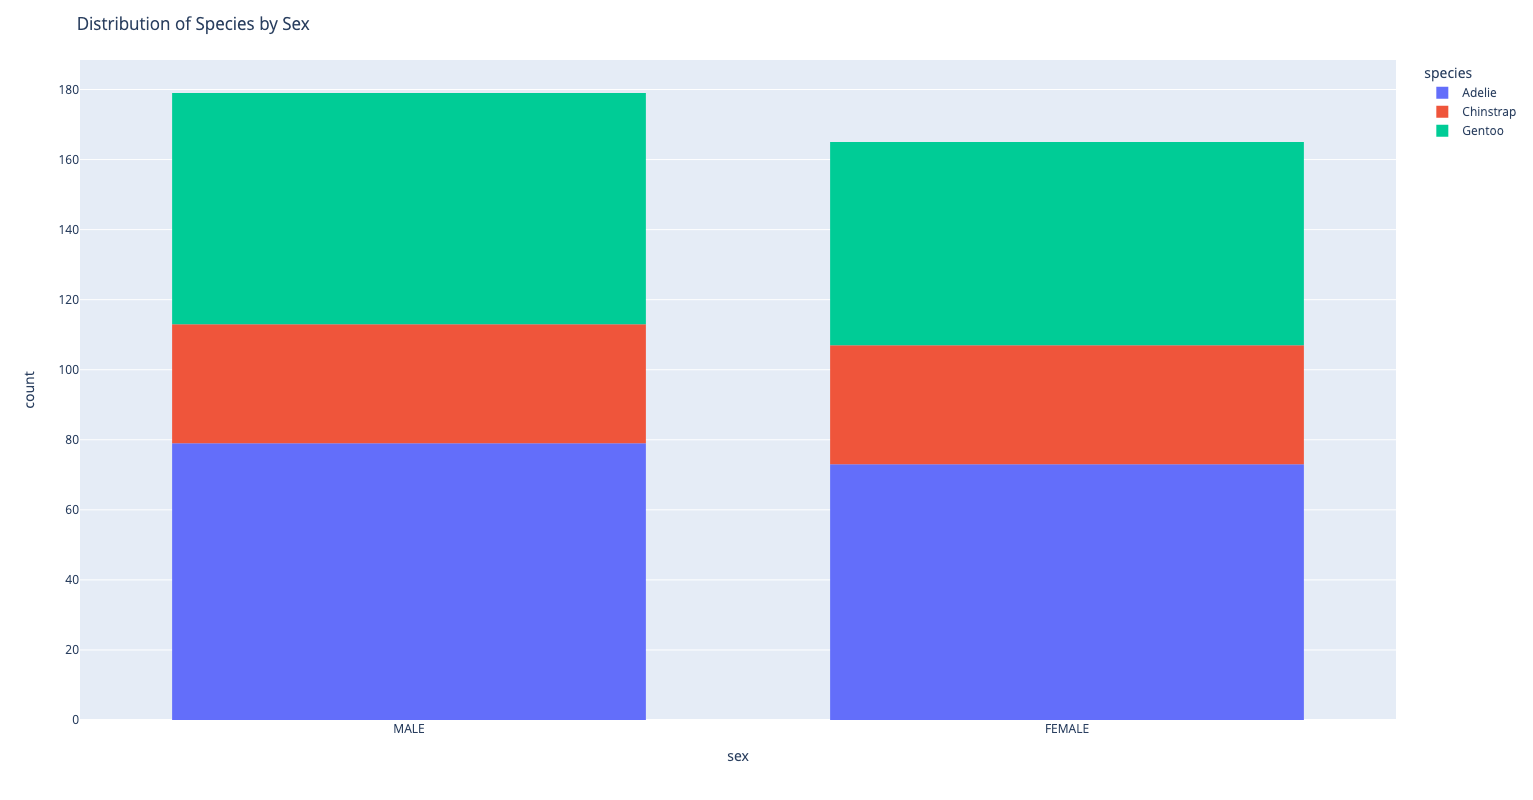

In [75]:
fig = px.histogram(penguins, x="sex", color="species", nbins=50)

fig.update_layout(
    height=800, 
    width=960, 
    title_text="Distribution of Species by Sex",
    xaxis_title_text='sex',
    yaxis_title_text='count',
    bargap=0.2,
    bargroupgap=0.1
)

fig.show()

## Step 2 - Creating the Preprocessing Script

The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run a script that will split and transform the data. This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.

The first step is to create the script that will split and transform the input data.

In [76]:
%%writefile {CODE_FOLDER}/preprocessor.py

import os
import sys
import argparse
import json
import tarfile
import tempfile
import time
import joblib
import numpy as np
import pandas as pd

from io import StringIO
from pathlib import Path
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder


def preprocess(base_directory):
    """
    This function loads the supplied data, splits it and transforms it.
    """

    df = _read_data_from_input_csv_files(base_directory)
    
    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])]
    )
    
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler()
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder()
    )
    
    features_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, make_column_selector(dtype_exclude="object")),
            ("categorical", categorical_transformer, ["island"]),
        ]
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(np.array(df_train.species.values).reshape(-1, 1))
    y_validation = target_transformer.transform(np.array(df_validation.species.values).reshape(-1, 1))
    y_test = target_transformer.transform(np.array(df_test.species.values).reshape(-1, 1))
    
    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)
    X_validation = features_transformer.transform(df_validation)
    X_test = features_transformer.transform(df_test)

    _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test)
    _save_model(base_directory, target_transformer, features_transformer)
    

def _read_data_from_input_csv_files(base_directory):
    """
    This function reads every CSV file available and concatenates
    them into a single dataframe.
    """

    input_directory = Path(base_directory) / "input"
    files = [file for file in input_directory.glob("*.csv")]
    
    if len(files) == 0:
        raise ValueError(f"The are no CSV files in {str(input_directory)}/")
        
    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)
    
    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """
    Splits the data into three sets: train, validation and test.
    """

    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_baseline(base_directory, df_test):
    """
    This function saves the untransformed test split to disk. This file will
    be used later as a baseline to monitor the performance of the model.
    """

    baseline_path = Path(base_directory) / f"baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)
    df_test.to_csv(baseline_path / "baseline.csv", header=False, index=False)


def _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test):
    """
    This function concatenates the transformed features and the target variable, and
    saves each one of the split sets to disk.
    """

    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(validation_path / "validation.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """
    This function creates a model.tar.gz file that contains the two transformation
    pipelines we built to transform the data.
    """

    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, os.path.join(directory, "target.joblib"))
        joblib.dump(features_transformer, os.path.join(directory, "features.joblib"))
    
        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)
    
        with tarfile.open(f"{str(model_path / 'model.tar.gz')}", "w:gz") as tar:
            tar.add(os.path.join(directory, "target.joblib"), arcname="target.joblib")
            tar.add(os.path.join(directory, "features.joblib"), arcname="features.joblib")

    
if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/preprocessor.py


## Step 3 - Testing the Preprocessing Script

Let's test the script to ensure everything is working as expected.

In [77]:
%%ipytest -s

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib
from preprocessor import preprocess


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    preprocess(base_directory=directory)
    
    yield directory
    
    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)
    
    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baseline(directory):
    output_directories = os.listdir(directory)

    assert "baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(directory / "baseline" / "baseline.csv", header=None)

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island

.....
5 passed in 0.42s


## Step 4 - Setting up the Processing Step

Let's now define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that we'll use in the pipeline.

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a paramater to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter. To read more about these parameters, check [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html). 

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch the Processing Job. To run the script, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK. The [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) page discusses other built-in processors you can use. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region.

The [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) requires a list of inputs that we need on the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [78]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.parameters import ParameterString


dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

processor = SKLearnProcessor(
    base_job_name="split-and-transform-data",
    framework_version="1.2-1",
    instance_type=config["instance_type"],
    instance_count=1,
    role=config["role"],
    sagemaker_session=config["session"],
)

split_and_transform_data_step = ProcessingStep(
    name="split-and-transform-data",
    step_args=processor.run(
        code=f"{CODE_FOLDER}/preprocessor.py",
        inputs=[
            ProcessingInput(source=dataset_location, destination="/opt/ml/processing/input"),  
        ],
        outputs=[
            ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
            ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
            ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
            ProcessingOutput(output_name="model", source="/opt/ml/processing/model"),
            
            # The baseline output points to the test set before transforming the data. This set
            # will be helpful to generate a quality baseline for the model performance.
            ProcessingOutput(output_name="baseline", source="/opt/ml/processing/baseline"),
        ]
    ),
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
/usr/local/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 5 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [79]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

session1_pipeline = Pipeline(
    name="session1-pipeline",
    parameters=[
        dataset_location
    ],
    steps=[
        split_and_transform_data_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session1_pipeline.upsert(role_arn=config["role"])

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session1-pipeline',
 'ResponseMetadata': {'RequestId': 'eac87151-a70b-47ee-ac04-9c3c671f37fb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'eac87151-a70b-47ee-ac04-9c3c671f37fb',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Tue, 17 Oct 2023 21:13:29 GMT'},
  'RetryAttempts': 0}}

## Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.1</strong></span> The SageMaker Pipeline we built supports running a few steps in Local Mode. The goal of this assignment is to run the pipeline on your local environment using Local Mode.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.2</strong></span> For this assignment, we want to run the end-to-end pipeline in SageMaker Studio. Ensure you turn off Local Mode before doing so.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.3</strong></span> The pipeline uses Random Sampling to split the dataset. Modify the code to use Stratified Sampling instead.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.4</strong></span> For this assignment, we want to run a distributed Processing Job across multiple instances to capitalize the `island` column of the dataset. Your dataset will consist of 10 different files stored in S3. Set up a Processing Job using two instances. When specifying the input to the Processing Job, you must set the `ProcessingInput.s3_data_distribution_type` attribute to `ShardedByS3Key`. By doing this, SageMaker will run a cluster with two instances simultaneously, each with access to half the files.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.5</strong></span> Pipeline steps can encounter exceptions. In some cases, retrying can resolve these issues. For this assignment, configure the Processing Step so it automatically retries the step a maximum of 5 times if it encounters an `InternalServerError`. Check the [Retry Policy for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-retry-policy.html) documentation for more information.

# Session 2 - Building Models And The Training Pipeline

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) we built in the previous session with a step to train a model. We'll explore the [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) and the [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). 

We'll introduce [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and use them during training. For more information about this topic, check the [SageMaker Experiments' SDK documentation](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html).

## Step 1 - Creating the Training Script

This following script is responsible for training a neural network using the train data, validating the model, and saving it so we can later use it.

In [80]:
%%writefile {CODE_FOLDER}/train.py

import os
import argparse

import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


def train(model_directory, train_path, validation_path, epochs=50, batch_size=32):
    train_files = [file for file in Path(train_path).glob("*.csv")]
    validation_files = [file for file in Path(validation_path).glob("*.csv")]
    
    if len(train_files) == 0 or len(validation_files) == 0:
        raise ValueError("The are no train or validation files")
        
    train_data = [pd.read_csv(file, header=None) for file in train_files]
    X_train = pd.concat(train_data)
    y_train = X_train[X_train.columns[-1]]
    X_train.drop(X_train.columns[-1], axis=1, inplace=True)
    
    
    validation_data = [pd.read_csv(file, header=None) for file in validation_files]
    X_validation = pd.concat(validation_data)
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation.drop(X_validation.columns[-1], axis=1, inplace=True)
    
    model = Sequential([
        Dense(10, input_shape=(X_train.shape[1],), activation="relu"),
        Dense(8, activation="relu"),
        Dense(3, activation="softmax"),
    ])
    
    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),
        epochs=epochs, 
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    print(f"Validation accuracy: {accuracy_score(y_validation, predictions)}")
    
    model_filepath = Path(model_directory) / "001"
    model.save(model_filepath)    
    

if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to 
    # the entry point as script arguments. 
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()
    

    train(
        # This is the location where we need to save our model. SageMaker will
        # create a model.tar.gz file with anything inside this directory when
        # the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR"],

        # SageMaker creates one channel for each one of the inputs to the
        # Training Step.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],

        epochs=args.epochs,
        batch_size=args.batch_size,
    )

Overwriting code/train.py


## Step 2 - Testing the Training Script

Let's test the script to ensure everything is working as expected.

In [81]:
%%ipytest -s

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib

from preprocessor import preprocess
from train import train


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        epochs=1
    )
    
    yield directory
    
    shutil.rmtree(directory)


def test_train_saves_a_folder_with_model_assets(directory):
    output = os.listdir(directory / "model")
    assert "001" in output
    
    assets = os.listdir(directory / "model" / "001")
    assert "saved_model.pb" in assets

8/8 - 1s - loss: 1.0882 - accuracy: 0.3083 - val_loss: 1.0793 - val_accuracy: 0.2885 - 867ms/epoch - 108ms/step


2/2 [==============================] - 0s 7ms/step
Validation accuracy: 0.28846153846153844


INFO:tensorflow:Assets written to: /tmp/tmp5sh9s1or/model/001/assets


.
1 passed in 2.00s


## Step 3 - Setting up the Training Step

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) that we can add to the pipeline. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information. 

SageMaker uses the concept of an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) to handle end-to-end training and deployment tasks. For this example, we will use the built-in [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator) to run the training script we wrote before. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region. Here, you can also check the available SageMaker [Deep Learning Container images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).

Notice the list of hyperparameters defined below. SageMaker will pass these hyperparameters as arguments to the entry point of the training script.

We are going to use [SageMaker Experiments](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html) to log information from the Training Job. For more information, check [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html). The list of metric definitions will tell SageMaker which metrics to track and how to parse them from the Training Job logs.

In [82]:
from sagemaker.tensorflow import TensorFlow


estimator = TensorFlow(
    base_job_name="training",
    entry_point=f"{CODE_FOLDER}/train.py",
    
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },

    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tells 
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],

    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    sagemaker_session=config["session"],
    role=config["role"],
)

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training). This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information. 

This step will receive the train and validation split from the previous step as inputs.

Here, we are using two input channels, `train` and `validation`. SageMaker will automatically create an environment variable corresponding to each of these channels following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAIN`: This environment variable will contain the path to the data in the `train` channel
* `SM_CHANNEL_VALIDATION`: This environment variable will contain the path to the data in the `validation` channel

In [83]:
from sagemaker.workflow.steps import TrainingStep
from sagemaker.inputs import TrainingInput


train_model_step = TrainingStep(
    name="train-model",
    step_args=estimator.fit(
        inputs={
            "train": TrainingInput(
                s3_data=split_and_transform_data_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv"
            ),
            "validation": TrainingInput(
                s3_data=split_and_transform_data_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv"
            )
        }
    ),
    cache_config=cache_config
)

/usr/local/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Setting up a Tuning Step

Let's now create a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). This Tuning Step will create a SageMaker Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one. Check the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep) SageMaker's SDK documentation for more information.

The Tuning Step requires a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) reference to configure the Hyperparameter Tuning Job.

Here is the configuration that we'll use to find the best model:

1. `objective_metric_name`: This is the name of the metric the tuner will use to determine the best model.
2. `objective_type`: This is the objective of the tuner. Should it "Minimize" the metric or "Maximize" it? In this example, since we are using the validation accuracy of the model, we want the objective to be "Maximize." If we were using the loss of the model, we would set the objective to "Minimize."
3. `metric_definitions`: Defines how the tuner will determine the metric's value by looking at the output logs of the training process.

The tuner expects the list of the hyperparameters you want to explore. You can use subclasses of the [Parameter](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange) class to specify different types of hyperparameters. This example explores different values for the `epochs` hyperparameter.

Finally, you can control the number of jobs and how many of them will run in parallel using the following two arguments:

* `max_jobs`: Defines the maximum total number of training jobs to start for the hyperparameter tuning job.
* `max_parallel_jobs`: Defines the maximum number of parallel training jobs to start.

In [84]:
from sagemaker.tuner import HyperparameterTuner
from sagemaker.parameter import IntegerParameter
from sagemaker.workflow.steps import TuningStep


# Since we could use the Training of the Tuning Step to create the model, 
# we'll define this constant to indicate which approach we want to run.
USE_TUNING_STEP = False


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name = "val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges = {
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions = [
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}
    ],
    max_jobs=3,
    max_parallel_jobs=3,
)

tune_model_step = TuningStep(
    name = "tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=split_and_transform_data_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv"
            ),
            "validation": TrainingInput(
                s3_data=split_and_transform_data_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv"
            )
        },
    ),
    cache_config=cache_config
)

## Step 5 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [85]:
session2_pipeline = Pipeline(
    name="session2-pipeline",
    parameters=[
        dataset_location
    ],
    steps=[
        split_and_transform_data_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session2_pipeline.upsert(role_arn=config["role"])

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session2-pipeline',
 'ResponseMetadata': {'RequestId': '10e93d0a-aacb-408d-a19f-a3444cf158db',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '10e93d0a-aacb-408d-a19f-a3444cf158db',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Tue, 17 Oct 2023 21:13:34 GMT'},
  'RetryAttempts': 0}}

## Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.1</strong></span> The training script trains the model using a hard-coded learning rate value. Modify the code to accept the learning rate as a parameter we can control from outside the script.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.2</strong></span> We currently define the number of epochs to train the model as a constant that we pass to the Estimator using the list of hyperparameters. Replace this constant with a new Pipeline Parameter named `training_epochs`. You'll need to specify this new parameter when creating the Pipeline.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.3</strong></span> The current tuning process aims to find the model with the highest validation accuracy. Modify the code to focus on the model with the lowest training loss.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.4</strong></span> We used an instance of [`SKLearnProcessor`](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to run the script that transforms and splits the data, but there's no way to add additional dependencies to the processing container. Modify the code to use an instance of [`FrameworkProcessor`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.FrameworkProcessor) instead. This class will allow you to specify a directory containing a `requirements.txt` file containing a list of dependencies. SageMaker will install these libraries in the processing container before triggering the processing job.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.5</strong></span> We want to execute the pipeline whenever the dataset changes. We can accomplish this by using [Amazon EventBridge](https://docs.aws.amazon.com/eventbridge/latest/userguide/eb-what-is.html). Configure an event to automatically start the pipeline when a new file is added to the S3 bucket where we store our dataset. Check [Amazon EventBridge Integration](https://docs.aws.amazon.com/sagemaker/latest/dg/pipeline-eventbridge.html) for an implementation tutorial.

# Session 3 - Evaluating and Versioning Models

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to evaluate the model and register it if it reaches a predefined accuracy threshold. 

We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [ScriptProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor) running TensorFlow to execute an evaluation script. We'll use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to determine whether the model's accuracy is above a threshold and a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. To learn more about the Model Registry, check [Register and Deploy Models with Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).

## Step 1 - Creating the Evaluation Script

Let's create the evaluation script. The Processing Step will spin up a Processing Job and run this script inside a container. This script is responsible for loading the model we created and evaluating it on the test set. Before finishing, this script will generate an evaluation report of the model.

In [86]:
%%writefile {CODE_FOLDER}/evaluation.py

import os
import json
import tarfile
import numpy as np
import pandas as pd

from pathlib import Path
from tensorflow import keras
from sklearn.metrics import accuracy_score


MODEL_PATH = "/opt/ml/processing/model/"
TEST_PATH = "/opt/ml/processing/test/"
OUTPUT_PATH = "/opt/ml/processing/evaluation/"


def evaluate(model_path, test_path, output_path):
    # The first step is to extract the model package so we can load 
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))
        
    model = keras.models.load_model(Path(model_path) / "001")
    
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test.drop(X_test.columns[-1], axis=1, inplace=True)
    
    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {
                "value": accuracy
            },
        },
    }
    
    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))
        
        
if __name__ == "__main__":
    evaluate(
        model_path=MODEL_PATH, 
        test_path=TEST_PATH,
        output_path=OUTPUT_PATH
    )

Overwriting code/evaluation.py


## Step 2 - Testing the Evaluation Script

Let's test the script to ensure everything is working as expected.

In [87]:
%%ipytest -s

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib
import json

from preprocessor import preprocess
from train import train
from evaluation import evaluate


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        epochs=1
    )
    
    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")
        
    evaluate(
        model_path=directory, 
        test_path=directory / "test",
        output_path=directory / "evaluation",
    )

    yield directory / "evaluation"
    
    shutil.rmtree(directory)


def test_evaluate_generates_evaluation_report(directory):
    output = os.listdir(directory)
    assert "evaluation.json" in output


def test_evaluation_report_contains_accuracy(directory):
    with open(directory / "evaluation.json", 'r') as file:
        report = json.load(file)
        
    assert "metrics" in report
    assert "accuracy" in report["metrics"]
    

8/8 - 1s - loss: 1.0741 - accuracy: 0.3208 - val_loss: 1.0394 - val_accuracy: 0.3846 - 854ms/epoch - 107ms/step
2/2 [==============================] - 0s 5ms/step
Validation accuracy: 0.38461538461538464


INFO:tensorflow:Assets written to: /tmp/tmp_ze51wmo/model/001/assets


2/2 [==============================] - 0s 5ms/step
Test accuracy: 0.39215686274509803
.

8/8 - 1s - loss: 1.0445 - accuracy: 0.4000 - val_loss: 1.0375 - val_accuracy: 0.4423 - 747ms/epoch - 93ms/step
2/2 [==============================] - 0s 9ms/step
Validation accuracy: 0.4423076923076923


INFO:tensorflow:Assets written to: /tmp/tmp33jk9oom/model/001/assets


2/2 [==============================] - 0s 6ms/step
Test accuracy: 0.3333333333333333
.
2 passed in 4.86s


## Step 3 - Setting up the Processing Step

To run the evaluation script, we can use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing). In this case, we'll use the [TensorFlowProcessor](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html) because we need access to TensorFlow. 

The inputs of this Processing Step will be the model we created and the test set. The output will be the evaluation report file.

We can use the `USE_TUNING_STEP` flag to determine whether we created the model using a Training Step or a Tuning Step. In case we are using the Tuning Step, we can use the [TuningStep.get_top_model_s3_uri()](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep.get_top_model_s3_uri) function to get the model artifacts from the top performing training job of the Hyperparameter Tuning Job.

The [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) lets us specify a list of [PropertyFile](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.properties.PropertyFile) instances from the output of the job. We can use this to map the evaluation report generated in the evaluation script. Check [How to Build and Manage Property Files](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html) for more information.

In [88]:
from sagemaker.tensorflow import TensorFlowProcessor
from sagemaker.workflow.properties import PropertyFile


tensorflow_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=config["role"],
    sagemaker_session=config["session"],
)

# We want to map the evaluation report that we generate inside
# the evaluation script so we can later reference it.
evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json"
)

# Notice how this step uses the model generated by the tuning or training
# step, and the test set generated by the preprocessing step.
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=tensorflow_processor.run(
        inputs=[
            ProcessingInput(
                source=split_and_transform_data_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test"
            ),
            ProcessingInput(
                source=(
                    tune_model_step.get_top_model_s3_uri(top_k=0, s3_bucket=config["session"].default_bucket()) 
                    if USE_TUNING_STEP 
                    else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
                ),
                destination="/opt/ml/processing/model",
            )
        ],
        outputs=[
            ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
        ],
        code=f"{CODE_FOLDER}/evaluation.py"
    ),
    property_files=[evaluation_report],
    cache_config=cache_config
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
/usr/local/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Registering the Model

We can now create a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. Check the [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) SageMaker's SDK documentation for more information. We want to create a new version of the model and register it in the Model Registry. Check [Register a Model Version](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) for more information about model registration.

The model we trained uses TensorFlow, so we can use the built-in [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) class to create an instance of the model. When we register a model, we can specify a set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics). We can use the evaluation report we generated during the Evaluation step to populate these statistics.

In [89]:
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.workflow.model_step import ModelStep
from sagemaker.model_metrics import ModelMetrics, MetricsSource
from sagemaker.workflow.functions import Join


MODEL_PACKAGE_GROUP = "penguins"

tensorflow_model = TensorFlowModel(
    model_data=(
        tune_model_step.get_top_model_s3_uri(
            top_k=0, s3_bucket=config["session"].default_bucket()
        )
        if USE_TUNING_STEP
        else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
    ),
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=config["role"],
)

# We'll use the evaluation report we generated during the
# Evaluation step to populate the metrics of this model.
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.arguments["ProcessingOutputConfig"]["Outputs"][0][
                    "S3Output"
                ]["S3Uri"],
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    )
)

register_model_step = ModelStep(
    name="register-model",
    step_args=tensorflow_model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        approval_status="Approved",
        model_metrics=model_metrics,
        content_types=["text/csv"],
        response_types=["text/csv"],
        # This is the suggested inference instance types when
        # deploying the model or using it as part of a batch
        # transform job.
        inference_instances=["ml.m5.xlarge"],
        transform_instances=["ml.m5.xlarge"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

INFO:sagemaker.processing:Uploaded None to s3://mlschool/evaluation-processor-2023-10-17-21-13-39-766/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/evaluation-processor-2023-10-17-21-13-39-766/source/runproc.sh


Using provided s3_resource


INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


## Step 5 - Setting up a Condition Step

We only want to register a new model if its accuracy exceeds a predefined threshold. We can use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) together with the evaluation report we generated to accomplish this. Check the [ConditionStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#conditionstep) SageMaker's SDK documentation for more information. In this example, we will use a [ConditionGreaterThanOrEqualTo](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo) condition to compare the model's accuracy with the threshold. Look at the [Conditions](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions) section in the documentation for more information about the types of supported conditions.

If the model's accuracy is not greater than or equal our threshold, we will send the pipeline to a [Fail Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail) with the appropriate error message. Check the [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) SageMaker's SDK documentation for more information.

We are going to use a new [Pipeline Parameter](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html) in our pipeline to specify the minimum accuracy that the model should reach for it to be registered.

In [90]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.functions import Join
from sagemaker.workflow.parameters import ParameterFloat
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep

accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)


# We want to check whether the accuracy of the model is greater than
# the threshold we defined.
condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=accuracy_threshold,
)

# If the condition is not met, we want to fail the execution
# of the pipeline by sending it to a FailStep.
fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the model's accuracy was lower than",
            accuracy_threshold,
        ],
    ),
)

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step] if not LOCAL_MODE else [],
    else_steps=[fail_step],
)

## Step 6 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [91]:
session3_pipeline = Pipeline(
    name="session3-pipeline",
    parameters=[
        dataset_location,
        accuracy_threshold
    ],
    steps=[
        split_and_transform_data_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session3_pipeline.upsert(role_arn=config["role"])

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session3-pipeline/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz


Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session3-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session3-pipeline/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session3-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session3-pipeline',
 'ResponseMetadata': {'RequestId': '8bcd4a73-055d-4f57-80e8-7dd81ab03302',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8bcd4a73-055d-4f57-80e8-7dd81ab03302',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Tue, 17 Oct 2023 21:13:41 GMT'},
  'RetryAttempts': 0}}

## Assignments

* <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.1</strong></span> The evaluation script computes the accuracy of the model and exports it as part of the evaluation report. Extend the evaluation report by adding the precision and the recall of the model on each one of the classes.

* <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.2</strong></span> The Condition Step uses a hard-coded threshold value to determine if the model's accuracy is good enough to proceed. Modify the code so the pipeline uses the accuracy of the latest registered model version as the threshold. We want to register a new model version only if its performance is better than the previous version we registered.

* <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.3</strong></span> We are using a QualityCheck Step to compute the baseline statistics and constraints from the input dataset. Right now, this step runs every time the pipeline runs. Modify the code to prevent the pipeline from continuing runing if the QualityCheck Step detects any violation on the data. Check [the different configuration settings of the QualityCheck Step](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html) for more information on how to accomplish this.

* <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.4</strong></span> The current pipeline uses either a Training Step or a Tuning Step to build a model. Modify the pipeline to use both steps at the same time. The evaluation script should evaluate the model coming from the Training Step and the best model coming from the Tuning Step and output the accuracy and location in S3 of the best model. You should modify the code to register the model assets specified in the evaluation report.

* <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.5</strong></span> Instead of running the entire pipeline from start to finish, sometimes you may only need to iterate over particular steps. SageMaker Pipelines supports [Selective Execution for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-selective-ex.html). In this assignment you will use Selective Execution to only run one specific step of the pipeline. [Unlocking efficiency: Harnessing the power of Selective Execution in Amazon SageMaker Pipelines](https://aws.amazon.com/blogs/machine-learning/unlocking-efficiency-harnessing-the-power-of-selective-execution-in-amazon-sagemaker-pipelines/) is a great article that explains this feature.

# Session 4 - Deploying Models and Serving Predictions

To deploy the model, we will use [Amazon EventBridge](https://aws.amazon.com/pm/eventbridge/) to trigger a Lambda function that will deploy the model whenever its status changes from "PendingManualApproval" to "Approved."

Deploying the model we trained directly to an endpoint doesn't lets us control the data that goes in and comes out of the endpoint. The TensorFlow model we trained requires the data to come in a specific format, which makes it useless to other applications. Fortunately, we can create an Inference Pipeline using SageMaker to control the data that goes in and comes out of the endpoint.

Our inference pipeline will have three components:

1. A preprocessing transformer that will transform the input data into the format the model expects. 
2. The TensorFlow model we trained.
3. A postprocessing transformer that will transform the output of the model into a human-readable format.

We want our endpoint to handle unprocessed data in CSV and JSON format and return the penguin's species. Here is an example of the payload input we want the endpoint to support:

```
{
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
}
```

And here is an example of the output we'd like to get from the endpoint:

```
{
    "prediction": "Adelie", 
    "confidence": 0.802672
}
```

## Step 1 - Deploying Model From Registry

Let's deploy the latest model from the Model Registry using SageMaker's SDK. To deploy a model from the Model Registry, we need to find its model package ARN. Let's query the list of approved models and get the latest one.

In [92]:
ENDPOINT = "penguins-endpoint"

response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=1,
)

package = response["ModelPackageSummaryList"][0] if response["ModelPackageSummaryList"] else None
package

{'ModelPackageGroupName': 'penguins',
 'ModelPackageVersion': 67,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:325223348818:model-package/penguins/67',
 'CreationTime': datetime.datetime(2023, 10, 17, 21, 7, 1, 325000, tzinfo=tzlocal()),
 'ModelPackageStatus': 'Completed',
 'ModelApprovalStatus': 'Approved'}

Using the ARN of the model package from the Model Registry, we can deploy the model by creating a [ModelPackage](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.ModelPackage) instance and calling its `deploy()` function. The model information lives in the Model Registry, so we don't need to specify anything else.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [93]:
%%script false --no-raise-error
from sagemaker import ModelPackage


model_package = ModelPackage(
    model_package_arn=package["ModelPackageArn"],
    sagemaker_session=sagemaker_session,
    role=execution_role,
)

model_package.deploy(
    endpoint_name=ENDPOINT, initial_instance_count=1, instance_type="ml.m5.xlarge"
)

Let's test the endpoint to make sure it works. Notice the payload we need to provide the model is in CSV format. The model expects data that's already transformed. We can't provide the original data from our dataset because the model will not work with it.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [94]:
%%script false --no-raise-error

# We'll send this payload to the endpoint. Notice how each line contains
# the information of a penguin. The endpoint will return the predictions
# for each of these lines.
payload = """
0.6569590202313976, -1.0813829646495108, 1.2097102831892812, 0.9226343641317372, 1.0, 0.0, 0.0
-0.7751048801481084, 0.8822689351285553,  -1.2168066120762704, 0.9226343641317372, 0.0, 1.0, 0.0
-0.837387834894918, 0.3386660813829646, -0.26237731892812, -1.92351941317372, 0.0, 0.0, 1.0
"""

# We can now send the request to the endpoint and process the response.
predictor = Predictor(endpoint_name=ENDPOINT)
response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
response = json.loads(response.decode("utf-8"))

print(json.dumps(response, indent=2))
print(f"\nSpecies: {np.argmax(response['predictions'], axis=1)}")

We can now delete the endpoint using the predictor.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [95]:
%%script false --no-raise-error

predictor.delete_endpoint()

## Step 2 - Creating the Preprocessing Script

The first component of our inference pipeline is a transformer that will transform the input data into the format the model expects. We'll use the Scikit-Learn transformer we saved when we split and transformed the data. To deploy this transformer as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the input data, and returns the output in the format the TensorFlow model expects.

In [96]:
%%writefile {INFERENCE_CODE_FOLDER}/preprocessing_component.py

import os
import numpy as np
import pandas as pd
import json
import joblib

from io import StringIO

try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # We don't have access to the `worker` instance when testing locally. 
    # We'll set it to None so we can change the way functions create a response.
    worker = None


TARGET_COLUMN = "species"
FEATURE_COLUMNS = [
    "island",
    "culmen_length_mm",
    "culmen_depth_mm", 
    "flipper_length_mm",
    "body_mass_g",
    "sex"
]


def input_fn(input_data, content_type):
    """
    Parses the input payload and creates a Pandas DataFrame.
    
    This function will check whether the target column is present in the
    input data, and will remove it.
    """
    
    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None, skipinitialspace=True)

        if len(df.columns) == len(FEATURE_COLUMNS) + 1:
            df = df.drop(df.columns[0], axis=1)
        
        df.columns = FEATURE_COLUMNS
        return df
    
    if content_type == "application/json":
        df = pd.DataFrame([json.loads(input_data)])
        
        if "species" in df.columns:
            df = df.drop("species", axis=1)
        
        return df
    
    else:
        raise ValueError(f"{content_type} is not supported.!")


def output_fn(prediction, accept):
    """
    Formats the prediction output to generate a response.
    
    The default accept/content-type between containers for serial inference is JSON. 
    Since this model will preceed a TensorFlow model, we want to return a JSON object
    following TensorFlow's input requirements.
    """
    
    if prediction is None:
        raise Exception(f"There was an error transforming the input data")

    if accept == "text/csv":
        return worker.Response(encoders.encode(prediction, accept), mimetype=accept) if worker else prediction, accept 
    
    if accept == "application/json":
        instances = [p for p in prediction.tolist()]
        response = {"instances": instances}
        return worker.Response(json.dumps(response), mimetype=accept) if worker else (response, accept)

    raise Exception(f"{accept} accept type is not supported.")


def predict_fn(input_data, model):
    """
    Preprocess the input using the transformer.
    """
    
    try:
        response = model.transform(input_data)
        return response
    except ValueError as e:
        print("Error transforming the input data", e)
        return None


def model_fn(model_dir):
    """
    Deserializes the model that will be used in this container.
    """
    
    return joblib.load(os.path.join(model_dir, "features.joblib"))

Overwriting code/inference/preprocessing_component.py


## Step 3 - Testing the Preprocessing Script

Let's test the script to ensure everything is working as expected.

In [97]:
%%ipytest

import json

from preprocessing_component import input_fn, predict_fn, output_fn, model_fn


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    
    with tarfile.open(directory / "model" / "model.tar.gz") as tar:
        tar.extractall(path=directory / "model")
    
    yield directory / "model"
    
    shutil.rmtree(directory)



def test_input_csv_drops_target_column_if_present():
    input_data = """
    Adelie, Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_json_drops_target_column_if_present():
    input_data = json.dumps({
        "species": "Adelie", 
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_csv_works_without_target_column():
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6


def test_input_json_works_without_target_column():
    input_data = json.dumps({
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6


def test_output_csv_raises_exception_if_prediction_is_none():
    with pytest.raises(Exception):
        output_fn(None, "text/csv")
    
    
def test_output_json_raises_exception_if_prediction_is_none():
    with pytest.raises(Exception):
        output_fn(None, "application/json")
    
    
def test_output_csv_returns_prediction():
    prediction = np.array([
        [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
        [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
    ])
    
    response = output_fn(prediction, "text/csv")
    
    assert response == (prediction, "text/csv")
    
    
def test_output_json_returns_tensorflow_ready_input():
    prediction = np.array([
        [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
        [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
    ])
    
    response = output_fn(prediction, "application/json")
    
    assert response[0] == {
        "instances": [
            [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
            [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
        ]
    }
    
    assert response[1] == "application/json"

    
def test_predict_transforms_data(directory):
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(str(directory))
    df = input_fn(input_data, "text/csv")
    response = predict_fn(df, model)
    assert type(response) is np.ndarray
    

def test_predict_returns_none_if_invalid_input(directory):
    input_data = """
    Invalid, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(str(directory))
    df = input_fn(input_data, "text/csv")
    assert predict_fn(df, model) is None

..........                                                                                   [100%]
10 passed in 0.22s


## Step 4 - Creating the Postprocessing Script

The final component of our inference pipeline is a transformer that will transform the output from the model into a human-readable format. We'll use the Scikit-Learn target transformer we saved when we split and transformed the data. To deploy this transformer as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the output from the model, and returns a human-readable format.

In [98]:
%%writefile {INFERENCE_CODE_FOLDER}/postprocessing_component.py

import os
import numpy as np
import pandas as pd
import argparse
import json
import tarfile
import joblib

from pathlib import Path
from io import StringIO

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from pickle import dump, load


try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # We don't have access to the `worker` instance when testing locally. 
    # We'll set it to None so we can change the way functions create a response.
    worker = None


def input_fn(input_data, content_type):
    if content_type == "application/json":
        predictions = json.loads(input_data)["predictions"]
        return predictions
    
    else:
        raise ValueError(f"{content_type} is not supported.!")


def output_fn(prediction, accept):
    if accept == "text/csv":
        return worker.Response(encoders.encode(prediction, accept), mimetype=accept) if worker else (prediction, accept)
    
    if accept == "application/json":
        response = []
        for p, c in prediction:
            response.append({
                "prediction": p,
                "confidence": c
            })
            
        return worker.Response(json.dumps(response), mimetype=accept) if worker else (response, accept)
    
    raise RuntimeException(f"{accept} accept type is not supported.")


def predict_fn(input_data, model):
    """
    Transforms the prediction into its corresponding category.
    """
    
    predictions = np.argmax(input_data, axis=-1)
    confidence = np.max(input_data, axis=-1)
    return [(confidence, model[prediction]) for confidence, prediction in zip(confidence, predictions)]


def model_fn(model_dir):
    """
    Deserializes the target model and returns the list of fitted categories.
    """
    
    model = joblib.load(os.path.join(model_dir, "target.joblib"))
    return model.named_transformers_["species"].categories_[0]

Overwriting code/inference/postprocessing_component.py


## Step 5 - Testing the Postprocessing Script

Let's test the script to ensure everything is working as expected.

In [99]:
%%ipytest

import json
import numpy as np

from postprocessing_component import predict_fn


def test_predict_returns_prediction_as_last_column():
    input_data = [
        [0.6, 0.2, 0.2], 
        [0.1, 0.8, 0.1],
        [0.2, 0.1, 0.7]
    ]
    
    categories = ["Adelie", "Gentoo", "Chinstrap"]
    
    response = predict_fn(input_data, categories)
    
    assert response == [
        (0.6, "Adelie"),
        (0.8, "Gentoo"),
        (0.7, "Chinstrap")
    ]

.                                                                                            [100%]
1 passed in 0.04s


## Step 6 - Setting up the Inference Pipeline

We can now create a [PipelineModel](https://sagemaker.readthedocs.io/en/stable/api/inference/pipeline.html#sagemaker.pipeline.PipelineModel) to define our inference pipeline. This Pipeline Model will create a SageMaker Model in the background and use the preprocessing and postprocessing scripts to transform the input and output of the model.

In [100]:
from sagemaker.workflow.functions import Join
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.pipeline import PipelineModel


# We'll use the model we generated from the first step of the
# pipeline as the input to the first and last components of the
# inference pipeline. This model.tar.gz file contains the two
# transformers we need to preprocess and postprocess the data.
transformation_pipeline_model = Join(
    on="/",
    values=[
        split_and_transform_data_step.properties.ProcessingOutputConfig.Outputs[
            "model"
        ].S3Output.S3Uri,
        "model.tar.gz",
    ],
)

# This is the first component of the inference pipeline. It will
# preprocess the data before sending it to the TensorFlow model.
preprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="preprocessing_component.py",
    source_dir=str(INFERENCE_CODE_FOLDER),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=config["role"],
)

# This is the last component of the inference pipeline. It will
# postprocess the output from the TensorFlow model before sending 
# it back to the user.
post_processing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="postprocessing_component.py",
    source_dir=str(INFERENCE_CODE_FOLDER),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=config["role"],
)

# We can now create the inference pipeline using the three models.
pipeline_model = PipelineModel(
    name="inference-model",
    models=[preprocessing_model, tensorflow_model, post_processing_model],
    sagemaker_session=config["session"],
    role=config["role"],
)

## Step 7 - Registering the Model

We can now register the pipeline model.

In [101]:
from sagemaker.workflow.model_step import ModelStep
from sagemaker.model_metrics import ModelMetrics, MetricsSource
from sagemaker.workflow.functions import Join


register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=pipeline_model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,

        model_metrics=model_metrics,
        approval_status="PendingManualApproval",

        # Our inference pipeline model supports two content
        # types: text/csv and application/json.
        content_types=["text/csv", "application/json"],
        response_types=["text/csv", "application/json"],
        
        # This is the suggested inference instance types when
        # deploying the model or using it as part of a batch
        # transform job.
        inference_instances=["ml.m5.xlarge"],
        transform_instances=["ml.m5.xlarge"],
        
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

/usr/local/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 8 - Modifying the Condition Step

We need to modify the [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to include the registration of the pipeline model.

In [102]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step] if not LOCAL_MODE else [],
    else_steps=[fail_step],
)

## Step 9 - Creating the Pipeline

In [103]:
session4_pipeline = Pipeline(
    name="session4-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        split_and_transform_data_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session4_pipeline.upsert(role_arn=config["role"])

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://mlschool/session4-pipeline/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://mlschool/session4-pipeline/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource
Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session4-pipeline',
 'ResponseMetadata': {'RequestId': 'c0e2652d-e2f9-4b2c-907b-3107cd1cdb7b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c0e2652d-e2f9-4b2c-907b-3107cd1cdb7b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Tue, 17 Oct 2023 21:13:45 GMT'},
  'RetryAttempts': 0}}

## Step 10 - Creating the Lambda Function

We will use [Amazon EventBridge](https://aws.amazon.com/pm/eventbridge/) to trigger a Lambda function that will deploy the model whenever its status changes from "PendingManualApproval" to "Approved." Let's start by writing the Lambda function to take the model information and create a new endpoint.

We'll enable [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) as part of the endpoint configuration. With Data Capture we can record the inputs and outputs of the endpoint to use them later for monitoring the model:
* `InitialSamplingPercentage` represents the percentage of traffic that we want to capture. 
* `DestinationS3Uri` specifies the S3 location where we want to store the captured data.


In [104]:
%%writefile {CODE_FOLDER}/lambda.py

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")

def lambda_handler(event, context):
    model_package_arn = event["detail"]["ModelPackageArn"]
    approval_status = event["detail"]["ModelApprovalStatus"]
    
    print(f'Model: "{model_package_arn}". Approval Status: "{approval_status}"')
    
    # We only want to deploy the model if it's new approval
    # status is "Approved."
    if approval_status != "Approved":
        return {
            "statusCode": 200,
            "body": json.dumps(f'Skipping deployment. Approval status: "{approval_status}"')
        }    
    
    
    endpoint_name = os.environ["ENDPOINT"]
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]
    
    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name, 
        ExecutionRoleArn=role, 
        Containers=[{
            "ModelPackageName": model_package_arn
        }] 
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[{
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "VariantName": "AllTraffic",
        }],
        
        # We can enable Data Capture to record the inputs and outputs of the endpoint
        # to use them later for monitoring the model. 
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": 100,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {
                    "CaptureMode": "Input"
                },
                {
                    "CaptureMode": "Output"
                },
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": [
                    "text/csv",
                    "application/octect-stream"
                ],
                "JsonContentTypes": [
                    "application/json",
                    "application/octect-stream"
                ]
            }
        },
    )
    
    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # If the endpoint doesn't exist, let's create it.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # If the endpoint already exist, let's update it with the
        # new configuration.
        sagemaker.update_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    
    return {
        "statusCode": 200,
        "body": json.dumps("Endpoint deployed successfully")
    }

Overwriting code/lambda.py


We need to ensure our Lambda function has permission to interact with SageMaker, so let's create a new role and then create the lambda function.

In [105]:
lambda_role_name = "lambda-deployment-role"
lambda_role_arn = None

try:
    response = iam_client.create_role(
        RoleName = lambda_role_name,
        AssumeRolePolicyDocument = json.dumps({
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {
                        "Service": [
                            "lambda.amazonaws.com",
                            "events.amazonaws.com"
                        ]
                    },
                    "Action": "sts:AssumeRole",
                }
            ]
        }),
        Description="Lambda Endpoint Deployment"
    )

    lambda_role_arn = response["Role"]["Arn"]
    
    iam_client.attach_role_policy(
        RoleName="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        PolicyArn=lambda_role_arn
    )
    
    iam_client.attach_role_policy(
        RoleName="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
        PolicyArn=lambda_role_arn
    )
    
    print(f'Role "{lambda_role_name}" created with ARN "{lambda_role_arn}".')
except iam_client.exceptions.EntityAlreadyExistsException:
    print(f"Role {lambda_role_name} already exists.")
    response = iam_client.get_role(RoleName=lambda_role_name)
    lambda_role_arn = response["Role"]["Arn"]

Role lambda-deployment-role already exists.


Let's create the Lambda function.

In [106]:
from sagemaker.lambda_helper import Lambda


DATA_CAPTURE_DESTINATION = f"{S3_LOCATION}/monitoring/data-capture"


deploy_lambda_fn = Lambda(
    function_name="deploy_fn",
    execution_role_arn=lambda_role_arn,
    script=str(CODE_FOLDER / "lambda.py"),
    handler="lambda.lambda_handler",
    timeout=600,
    session=sagemaker_session,
    runtime="python3.11",
    environment={
        "Variables": {
            "ENDPOINT": ENDPOINT,
            "DATA_CAPTURE_DESTINATION": DATA_CAPTURE_DESTINATION,
            "ROLE": config["role"]
        }
    }
)

lambda_response = None
if not LOCAL_MODE:
    lambda_response = deploy_lambda_fn.upsert()

lambda_response

{'ResponseMetadata': {'RequestId': 'db1eceed-9f37-4d94-a3dd-d3ae39732045',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 17 Oct 2023 21:13:46 GMT',
   'content-type': 'application/json',
   'content-length': '1428',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'db1eceed-9f37-4d94-a3dd-d3ae39732045'},
  'RetryAttempts': 0},
 'FunctionName': 'deploy_fn',
 'FunctionArn': 'arn:aws:lambda:us-east-1:325223348818:function:deploy_fn',
 'Runtime': 'python3.11',
 'Role': 'arn:aws:iam::325223348818:role/lambda-deployment-role',
 'Handler': 'lambda.lambda_handler',
 'CodeSize': 3142,
 'Description': '',
 'Timeout': 600,
 'MemorySize': 128,
 'LastModified': '2023-10-17T21:13:46.000+0000',
 'CodeSha256': 'WqHyuUD9XDamOwwe1F2HS9RyWSObIDwmg/EvGSBqKjU=',
 'Version': '$LATEST',
 'Environment': {'Variables': {'ROLE': 'arn:aws:iam::325223348818:role/service-role/AmazonSageMaker-ExecutionRole-20230312T160501',
   'DATA_CAPTURE_DESTINATION': 's3://mlschool/penguins/monitoring/data-captur

## Step 11 - Setting Up EventBridge

Let's create an EventBridge rule that triggers the deployment process whenever a model approval status becomes "Approved". 

In [107]:
events_client = boto3.client("events")
lambda_client = boto3.client("lambda")

event_pattern = f"""
{{
  "source": ["aws.sagemaker"],
  "detail-type": ["SageMaker Model Package State Change"],
  "detail": {{
    "ModelPackageGroupName": ["{MODEL_PACKAGE_GROUP}"],
    "ModelApprovalStatus": ["Approved"]
  }}
}}
"""

rule_response = None
if not LOCAL_MODE:
    rule_response = events_client.put_rule(
        Name="model-approval-rule",
        EventPattern=event_pattern,
        State="ENABLED",
        RoleArn=config["role"],
    )

    response = events_client.put_targets(
        Rule="model-approval-rule",
        Targets=[
            {
                "Id": "1",
                "Arn": lambda_response["FunctionArn"],
            }
        ],
    )

    try:
        response = lambda_client.add_permission(
            Action="lambda:InvokeFunction",
            FunctionName=lambda_response["FunctionName"],
            Principal="events.amazonaws.com",
            SourceArn=rule_response["RuleArn"],
            StatementId="EventBridge",
        )
    except lambda_client.exceptions.ResourceConflictException as e:
        print(f'Function "{lambda_response["FunctionName"]}" already has the correct permissions.')

Function "deploy_fn" already has the correct permissions.


## Step 12 - Testing the Endpoint

Let's now test the endpoint we deployed automatically with the pipeline. We will use the function to create a predictor with a JSON encoder and decoder. 

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [108]:
%%script false --no-raise-error

from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer


waiter = sagemaker_client.get_waiter("endpoint_in_service")
waiter.wait(
    EndpointName=ENDPOINT,
    WaiterConfig={
        "Delay": 10,
        "MaxAttempts": 30
    }
)

predictor = Predictor(
    endpoint_name=ENDPOINT, 
    serializer=CSVSerializer(),
    sagemaker_session=sagemaker_session
)

data = pd.read_csv(DATA_FILEPATH)
data = data.drop("species", axis=1)

payload = data.iloc[:3].to_csv(header=False, index=False)
response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
print(response.decode("utf-8"))

In [109]:
%%script false --no-raise-error

predictor.delete_endpoint()

## Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.1</strong></span> Every Endpoint has an invocation URL you can use to generate predictions with the model from outside AWS. As part of this assignment, write a simple Python script that will run on your local computer and run a few samples through the Endpoint. You will need your AWS access key and secret to connect to the Endpoint.


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.2</strong></span> We can use model variants to perform A/B testing between a new model and an old model. Create a function that given the ARN of two models in the Model Registry deploys them to an Endpoint as separate variants. Each variant should receive 50% of the traffic. Write another function that invokes the endpoint by default, but allows the caller to invoke a specific variant if they want to.


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.3</strong></span> We can use SageMaker Model Shadow Deployments to create shadow variants to validate a new model version before promoting it to production. Write a function that given the ARN of a model in the Model Registry, updates an Endpoint and deploys the model as a shadow variant. Check [Shadow variants](https://docs.aws.amazon.com/sagemaker/latest/dg/model-shadow-deployment.html) for more information about this topic. Send some traffic to the Endpoint and compare the results from the main model with its shadow variant.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.4</strong></span> SageMaker supports auto scaling your models. Auto scaling dynamically adjusts the number of instances provisioned for a model in response to changes in the workload. For this assignment, define a target-tracking scaling policy for a variant of your Endpoint and use the `SageMakerVariantInvocationsPerInstance` metric. `SageMakerVariantInvocationsPerInstance` is the average number of times per minute that the variant is invoked. Check [Automatically Scale Amazon SageMaker Models](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html) for more information about auto scaling models.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.5</strong></span> Modify the SageMaker Pipeline you created for the "Pipeline of Digits" project and add a Lambda Step to deploy the model automatically. Create a custom inference script so the endpoint receives a JSON containing the URL of an image, and returns a single value representing the predicted digit.

# Session 6 - Monitoring

In this session we'll set up a monitoring process to analyze the quality of the data our endpoint receives and the endpoint predictions. For this, we need to check the data received by the endpoint, generate ground truth labels, and compare them with a baseline performance.

To enable this functionality, we need a couple of steps:

1. Create baselines we can use to compare against real-time traffic.
2. Set up a schedule to continuously evaluate and compare against the baselines.

Notice that we use the baseline datasets we generated during the Processing Step. These baseline datasets are the same unprocessed data in JSON format. We do this because we need raw data to compare against the endpoint input.

Check [Amazon SageMaker Model Monitor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_monitoring.html) for a brief explanation of how to use SageMaker's Model Monitoring functionality. [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) is a much more extensive guide to monitoring in Amazon SageMaker.

In [462]:
import random

from datetime import datetime
from IPython.display import JSON

from time import sleep
from threading import Thread, Event
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.quality_check_step import DataQualityCheckConfig, QualityCheckStep, ModelQualityCheckConfig
from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.drift_check_baselines import DriftCheckBaselines
from sagemaker.workflow.parameters import ParameterBoolean
from sagemaker.model import Model
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import CreateModelInput, TransformInput
from sagemaker.transformer import Transformer
from sagemaker.workflow.steps import CreateModelStep, TransformStep
from sagemaker.model_monitor import (
    CronExpressionGenerator, DefaultModelMonitor, MonitoringExecution,
    ModelQualityMonitor, EndpointInput
)

GROUND_TRUTH_LOCATION = f"{S3_LOCATION}/monitoring/groundtruth"
DATA_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/data-quality"
MODEL_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/model-quality"

## Step 1 - Checking Captured Data

Let's check the S3 location where the endpoint stores the requests and responses that it receives.

Notice that it make take a few minutes for the first few files to show up in S3. Keep running the following line until you get some.

In [463]:
files = S3Downloader.list(data_capture_destination.default_value)[:3]
files

['s3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/13/02-51-901-6e45327a-2e33-464e-a495-b93f521ce18d.jsonl',
 's3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/15/12-21-655-52e1be77-afee-40ab-b9a9-26574fecfbc1.jsonl',
 's3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/18/48-48-630-660a23bf-6952-4941-9278-3c539bdc15eb.jsonl']

These files contain the data captured by the endpoint in a SageMaker-specific JSON-line format. Each inference request is captured in a single line in the `jsonl` file. The line contains both the input and output merged together.

Let's read the first line from the first file:

In [464]:
if len(files):
    lines = S3Downloader.read_file(files[0])
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "{\"island\": \"Dream\", \"culmen_length_mm\": 46.4, \"culmen_depth_mm\": 18.6, \"flipper_length_mm\": 190.0, \"body_mass_g\": 3450.0}",
      "encoding": "JSON"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\"prediction\": \"Adelie\", \"confidence\": 0.531686723}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "0c745f20-c492-43b0-887f-968f2443d651",
    "inferenceTime": "2023-07-31T13:02:51Z"
  },
  "eventVersion": "0"
}


## Step 2 - Generating a Data Drift Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the train set we generated in the preprocessing step.

We can configure the instance that will run the quality check using the [CheckJobConfig](https://sagemaker.readthedocs.io/en/v2.73.0/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.check_job_config.CheckJobConfig) class, and we can use the `DataQualityCheckConfig` class to configure the job.

In [465]:
data_quality_baseline_step = QualityCheckStep(
    name="generate-data-quality-baseline",
    
    check_job_config = CheckJobConfig(
        instance_type="ml.t3.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    
    quality_check_config = DataQualityCheckConfig(
        # We will use the train dataset we generated during the preprocessing 
        # step to generate the data quality baseline.
        baseline_dataset=preprocess_data_step.properties.ProcessingOutputConfig.Outputs["train-baseline"].S3Output.S3Uri,

        dataset_format=DatasetFormat.json(lines=True),
        output_s3_uri=DATA_QUALITY_LOCATION
    ),
    
    skip_check=True,
    register_new_baseline=True,
    model_package_group_name=MODEL_PACKAGE_GROUP,
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Step 3 - Creating Test Predictions

To create a baseline to compare the model performance, we must create predictions for the test set and compare them with the predictions from the model. We can do this by running a Batch Transform Job to predict every sample from the test dataset. We can use a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) as part of the pipeline to run this job. You can check [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) for more information about Batch Transform Jobs.

The Transform Step requires a model to generate predictions, so we need a Model Step that creates a model.

We also need to configure the [Batch Transform Job](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) using a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform). This Batch Transform Job will run every sample from the training dataset through the model so we can compute the baseline metrics. We can use an instance of the [Transformer](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) class to configure the job.

In [466]:
create_model_step = ModelStep(
    name="create",
    display_name="create-model",
    step_args=model.create(
        instance_type="ml.m5.large"
    ),
)

transformer = Transformer(
    model_name=create_model_step.properties.ModelName,
    base_transform_job_name="transform",

    instance_type="ml.c5.xlarge",
    instance_count=1,
    
    accept="application/json",
    strategy="SingleRecord",
    assemble_with="Line",
    
    output_path=f"{S3_LOCATION}/transform",
    sagemaker_session=pipeline_session
)

generate_test_predictions_step = TransformStep(
    name="generate-test-predictions",
    step_args=transformer.transform(
        # We will use the test dataset we generated during the preprocessing 
        # step to run it through the model and generate predictions.
        data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs["test-baseline"].S3Output.S3Uri,

        join_source="Input",
        content_type="application/json",
        split_type="Line",
        output_filter="$.SageMakerOutput['prediction','groundtruth']",
    ),
    cache_config=cache_config
)

/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Generating a Model Drift Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the data we generated in the Transform Step.

In [467]:
model_quality_location = f"{S3_LOCATION}/monitoring/model-quality"

model_quality_baseline_step = QualityCheckStep(
    name="generate-model-quality-baseline",
    
    check_job_config = CheckJobConfig(
        instance_type="ml.t3.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    
    quality_check_config = ModelQualityCheckConfig(
        # We are going to use the output of the Transform Step to generate
        # the model quality baseline.
        baseline_dataset=generate_test_predictions_step.properties.TransformOutput.S3OutputPath,

        dataset_format=DatasetFormat.json(lines=True),

        # We need to specify the problem type and the fields where the prediction
        # and groundtruth are so the process knows how to interpret the results.
        problem_type="MulticlassClassification",
        inference_attribute="prediction",
        ground_truth_attribute="groundtruth",

        output_s3_uri=model_quality_location,
    ),
    
    skip_check=True,
    register_new_baseline=True,
    model_package_group_name=MODEL_PACKAGE_GROUP,
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Step 5 - Setting up Model Metrics

We can configure a new set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) using the results of the Data and Model Quality Steps. Check [Baseline and model version lifecycle and evolution with SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html#pipelines-quality-clarify-baseline-evolution) for an explanation of how SageMaker uses the `DriftCheckBaselines`.

In [468]:
model_metrics = ModelMetrics(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    )
)

## Step 6 - Registering the Model

We need to redefine the Model Step to register the [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) so it takes into account the new metrics.

In [469]:
register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        drift_check_baselines=drift_check_baselines,
        approval_status="Approved",
        content_types=["application/json"],
        response_types=["application/json"],
        inference_instances=["ml.m5.large"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version="2.6",
    )
)

## Step 7 - Setting up the Condition Step

We only want to compute the model quality baseline if the model's performance is above the predefined threshold. The [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) will gate all necessary steps to compute the baseline. 

In [470]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition_gte],
    if_steps=[
        create_model_step, 
        generate_test_predictions_step, 
        model_quality_baseline_step, 
        register_model_step,
        deploy_step
    ],
    else_steps=[fail_step], 
)

## Step 8 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [471]:
session6_pipeline = Pipeline(
    name="penguins-session6",
    parameters=[
        dataset_location, 
        data_capture_percentage,
        data_capture_destination,
        accuracy_threshold,
    ],
    steps=[
        preprocess_data_step, 
        data_quality_baseline_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session6_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/penguins-session6/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/penguins-session6/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource
Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session6',
 'ResponseMetadata': {'RequestId': '4c02b133-01d0-4c83-bf4f-0170a3ee5158',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4c02b133-01d0-4c83-bf4f-0170a3ee5158',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Sat, 23 Sep 2023 19:08:06 GMT'},
  'RetryAttempts': 0}}

## Step 9 - Generating Traffic and Labels

To test the monitoring functionality, we need to generate some traffic to the endpoint and label the samples captured by the endpoint. 

To generate traffic, we will repeatedly send every sample from the dataset to the endpoint to simulate real prediction requests. We can simulate the labeling process by generating a random label for every sample. Check [Ingest Ground Truth Labels and Merge Them With Predictions](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-merge.html) for more information about this.

The following function will generate the traffic to the endpoint.

In [472]:
def generate_traffic(predictor):
    
    def _predict(data, predictor, stop_traffic_thread):
        for index, row in data.iterrows():
            predictor.predict(row.to_dict(), inference_id=str(index))
            
            sleep(1)

            if stop_traffic_thread.is_set():
                break

    def _generate_prediction_data(data, predictor, stop_traffic_thread):
        while True:
            print(f"Generating {data.shape[0]} predictions...")
            _predict(data, predictor, stop_traffic_thread)
            
            if stop_traffic_thread.is_set():
                break

                
    stop_traffic_thread = Event()
    
    data = pd.read_csv(DATA_FILEPATH).dropna()
    data.drop(["sex"], axis=1, inplace=True)
    
    traffic_thread = Thread(
        target=_generate_prediction_data,
        args=(data, predictor, stop_traffic_thread,)
    )
    
    traffic_thread.start()
    
    return stop_traffic_thread, traffic_thread

The following function will generate random labels.

In [473]:
def generate_ground_truth_data(predictor, ground_truth_location):
    
    def _generate_ground_truth_record(inference_id):
        random.seed(inference_id)

        return {
            "groundTruthData": {
                "data": random.choice(["Adelie", "Chinstrap", "Gentoo"]),
                "encoding": "CSV",
            },
            "eventMetadata": {
                "eventId": str(inference_id),
            },
            "eventVersion": "0",
        }


    def _upload_ground_truth(records, upload_time):
        records = [json.dumps(r) for r in records]
        data = "\n".join(records)
        uri = f"{ground_truth_location}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"

        print(f"Uploading ground truth data to {uri}...")

        S3Uploader.upload_string_as_file_body(data, uri)    

                
    def _generate_ground_truth_data(max_records, stop_ground_truth_thread):
        while True:
            records = [_generate_ground_truth_record(i) for i in range(max_records)]
            _upload_ground_truth(records, datetime.utcnow())

            if stop_ground_truth_thread.is_set():
                break

            sleep(30)

                
    stop_ground_truth_thread = Event()
    data = pd.read_csv(DATA_FILEPATH).dropna()
    
    groundtruth_thread = Thread(
        target=_generate_ground_truth_data,
        args=(len(data), stop_ground_truth_thread,)
    )
    
    groundtruth_thread.start()
    
    return stop_ground_truth_thread, groundtruth_thread

Let's wait for the endpoint to be in service, and then we can start generating traffic and labels.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [474]:
%%script false --no-raise-error

waiter = sagemaker_client.get_waiter("endpoint_in_service")
waiter.wait(
    EndpointName=ENDPOINT,
    WaiterConfig={
        "Delay": 10,
        "MaxAttempts": 30
    }
)

predictor = Predictor(endpoint_name=ENDPOINT, serializer=JSONSerializer(), deserializer=JSONDeserializer())

stop_traffic_thread, traffic_thread = generate_traffic(predictor)

stop_ground_truth_thread, groundtruth_thread = generate_ground_truth_data(
    predictor, 
    GROUND_TRUTH_LOCATION
)

Let's make a prediction for a penguin and include extra fields in the request. This should be flagged by the monitoring job.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [475]:
%%script false --no-raise-error

predictor.predict({
    "island": "Dream",
    "culmen_length_mm": 46.4,
    "culmen_depth_mm": 18.6,
    "flipper_length_mm": 190.0,
    "body_mass_g": 5608.0,
    
    # These two columns are not in the baseline data,
    # so they will be reported by the monitoring job
    # as a violation.
    "name": "Johnny",
    "height": 28.0
})

## Step 10 - Setting Up Monitoring Jobs

We can now schedule the Monitoring Jobs to continuously monitor the data going into the endpoint and the model performance. We will use the baseline we generated in the pipeline to determine when there's drift. Check [Schedule Data Quality Monitoring Jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-schedule-data-monitor.html) and [Schedule Model Quality Monitoring Jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-schedule.html) for more information.

The following functions will help us work with monitoring schedules later on.

In [476]:
def describe_monitoring_schedules(endpoint_name):
    schedules = []
    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)["MonitoringScheduleSummaries"]
    for item in response:
        name = item["MonitoringScheduleName"]
        schedule = {
            "MonitoringScheduleName": name,
            "MonitoringType": item["MonitoringType"]
        }
        
        description = sagemaker_client.describe_monitoring_schedule(
            MonitoringScheduleName=name
        )
        
        schedule["Status"] = description["LastMonitoringExecutionSummary"]["MonitoringExecutionStatus"]
        
        if schedule["Status"] == "Failed":
            schedule["FailureReason"] = description["LastMonitoringExecutionSummary"]["FailureReason"]
        elif schedule["Status"] == "CompletedWithViolations":
            processing_job_arn = description["LastMonitoringExecutionSummary"]["ProcessingJobArn"]
            execution = MonitoringExecution.from_processing_arn(
                sagemaker_session=sagemaker_session, 
                processing_job_arn=processing_job_arn
            )
            execution_destination = execution.output.destination

            violations_filepath = os.path.join(execution_destination, "constraint_violations.json")
            violations = json.loads(S3Downloader.read_file(violations_filepath))["violations"]
            
            schedule["Violations"] = violations

        schedules.append(schedule)
        
    return schedules

def describe_monitoring_schedule(endpoint_name, monitoring_type):
    found = False
    
    schedules = describe_monitoring_schedules(endpoint_name)
    for schedule in schedules:
        if schedule["MonitoringType"] == monitoring_type:
            found = True
            print(json.dumps(schedule, indent=2))

    if not found:            
        print(f"There's no {monitoring_type} Monitoring Schedule.")


def describe_data_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "DataQuality")

    
def describe_model_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "ModelQuality")

    
def delete_monitoring_schedule(endpoint_name, monitoring_type):
    attempts = 30
    found = False
    
    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)["MonitoringScheduleSummaries"]
    for item in response:
        if item["MonitoringType"] == monitoring_type:
            found = True
            status = sagemaker_client.describe_monitoring_schedule(
                MonitoringScheduleName=item["MonitoringScheduleName"]
            )["MonitoringScheduleStatus"]
            while status in ("Pending", "InProgress") and attempts > 0:
                attempts -= 1
                print(f"Monitoring schedule status: {status}. Waiting for it to finish.")
                sleep(30)
                
                status = sagemaker_client.describe_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )["MonitoringScheduleStatus"]

            if status not in ("Pending", "InProgress"):
                sagemaker_client.delete_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )
                print("Monitoring schedule deleted.")
            else:
                print("Waiting for monitoring schedule timed out")
                
    if not found:            
        print(f"There's no {monitoring_type} Monitoring Schedule.")

        
def delete_data_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "DataQuality")

    
def delete_model_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "ModelQuality")

Our pipeline generated data baseline statistics and constraints using our train set. We can take a look at what these values look like by downloading them from S3.

In [477]:
statistics = f"{DATA_QUALITY_LOCATION}/statistics.json"

response = None
try:
    response = json.loads(S3Downloader.read_file(statistics))
except Exception as e:
    pass

JSON(response or {})

<IPython.core.display.JSON object>

In [478]:
constraints = f"{DATA_QUALITY_LOCATION}/constraints.json"

response = None
try:
    response = json.loads(S3Downloader.read_file(constraints))
except Exception as e:
    pass

JSON(response or {})

<IPython.core.display.JSON object>

We also generated the baseline performance using the test set.

In [479]:
constraints = f"{MODEL_QUALITY_LOCATION}/constraints.json"

response = None
try:
    response = json.loads(S3Downloader.read_file(constraints))
except Exception as e:
    pass

JSON(response or {})

<IPython.core.display.JSON object>

SageMaker looks for violations in the data captured by the endpoint. By default, it combines the input data with the endpoint output and compare the result with the baseline we generated. If we let SageMaker do this, we will get a few violations, for example an "extra column check" violation because the field `confidence` doesn't exist in the baseline data.

We can fix these violations by creating a preprocessing script configuring the data we want the monitoring job to use. Check [Preprocessing and Postprocessing](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-and-post-processing.html) for more information about how to configure these scripts.

In [480]:
DATA_QUALITY_PREPROCESSOR = "data_quality_preprocessor.py"

In [481]:
%%writefile {CODE_FOLDER}/{DATA_QUALITY_PREPROCESSOR}
import json

def preprocess_handler(inference_record):
    input_data = inference_record.endpoint_input.data
    output_data = json.loads(inference_record.endpoint_output.data)
    
    response = json.loads(input_data)
    response["species"] = output_data["prediction"]

    # The `response` variable contains the data that we want the
    # monitoring job to use to compare with the baseline.
    return response

Overwriting code/data_quality_preprocessor.py


The monitoring schedule expects an S3 location pointing to the preprocessing script. Let's upload the script to the default bucket.

In [482]:
bucket = boto3.Session().resource("s3").Bucket(pipeline_session.default_bucket())
prefix = "penguins-monitoring"
bucket.Object(os.path.join(prefix, DATA_QUALITY_PREPROCESSOR)).upload_file(str(CODE_FOLDER / DATA_QUALITY_PREPROCESSOR))
data_quality_preprocessor = f"s3://{os.path.join(bucket.name, prefix, DATA_QUALITY_PREPROCESSOR)}"
data_quality_preprocessor

's3://mlschool/penguins-monitoring/data_quality_preprocessor.py'

We can now set up the Data Quality Monitoring Job using the [DefaultModelMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.DefaultModelMonitor) class. Notice how we specify the `record_preprocessor_script` using the S3 location where we uploaded our script.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [483]:
%%script false --no-raise-error

data_monitor = DefaultModelMonitor(
    instance_type="ml.m5.xlarge",
    instance_count=1,
    max_runtime_in_seconds=3600,
    role=role,
)

data_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-data-monitoring-schedule",
    endpoint_input=ENDPOINT,
    record_preprocessor_script=data_quality_preprocessor,
    statistics=f"{DATA_QUALITY_LOCATION}/statistics.json",
    constraints=f"{DATA_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

We can check the results of the monitoring job by looking at whether it generated any violations.

In [484]:
describe_data_monitoring_schedule(ENDPOINT)

There's no DataQuality Monitoring Schedule.


To set up a Model Quality Monitoring Job, we can use the [ModelQualityMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelQualityMonitor) class. The [EndpointInput](https://sagemaker.readthedocs.io/en/v2.24.2/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.EndpointInput) instance configures the attribute the monitoring job should use to determine the prediction from the model.

Check [Amazon SageMaker Model Quality Monitor](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/model_quality/model_quality_churn_sdk.html) for a complete tutorial on how to run a Model Monitoring Job in SageMaker.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [485]:
%%script false --no-raise-error

model_monitor = ModelQualityMonitor(
    instance_type="ml.m5.xlarge",
    instance_count=1,
    max_runtime_in_seconds=1800,
    role=role
)

model_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-model-monitoring-schedule",
    
    endpoint_input = EndpointInput(
        endpoint_name=ENDPOINT,
        inference_attribute="prediction",
        destination="/opt/ml/processing/input_data",
    ),
    
    problem_type="MulticlassClassification",
    ground_truth_input=GROUND_TRUTH_LOCATION,
    
    constraints=f"{MODEL_QUALITY_LOCATION}/constraints.json",
    
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=f"{S3_LOCATION}/monitoring/model-quality",
    enable_cloudwatch_metrics=True,
)

We can check the results of the monitoring job by looking at whether it generated any violations.

In [486]:
describe_model_monitoring_schedule(ENDPOINT)

There's no ModelQuality Monitoring Schedule.


The following code will stop the generation of traffic and labels, delete the monitoring jobs, and delete the endpoint.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [487]:
%%script false --no-raise-error

stop_traffic_thread.set()
traffic_thread.join()

stop_ground_truth_thread.set()
groundtruth_thread.join()

delete_data_monitoring_schedule(ENDPOINT)
delete_model_monitoring_schedule(ENDPOINT)

Let's now delete the endpoint.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [488]:
%%script false --no-raise-error

predictor.delete_endpoint()

## Questions

Answering these questions will help you understand the material we discussed during this session. Notice that each question could have one or more correct answers.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.1</strong></span></div>

To compute the data and the model quality baselines, we use the `train-baseline` and `test-baseline` outputs from the Preprocessing step of the pipeline. Which of the following is the reason we don't use the `train` and `test` outputs?

1. The `train` and `test` outputs are being used in the Train and Evaluation steps, and SageMaker doesn't allow to reuse outputs across a pipeline.
2. Computing the two baselines requires the data to be transformed with the SciKit-Learn pipeline we created as part of the Preprocessing step.
3. Computing the two baselines requires the data to be in its original format.
4. Computing the two baselines requires JSON data, but the `train` and `test` outputs are in CSV format.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.2</strong></span></div>

You build a computer vision model to recognize the brand and model of luxury handbags. After you deploy the model, one of the most important brands releases a new handbag that your model can't predict. How would you classify this type of model drift?

1. Sudden drift.
2. Gradual drift.
3. Incremental drift.
4. Reocurring drift.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.3</strong></span></div>

We use a custom script as part of the creation of the Data Monitoring schedule. Why do we need this custom script?

1. This script expands the input data with the fields coming from the endpoint output.
2. This script combines the input data with the endpoint output.
3. This script prevents the monitoring job from reporting superfluous violations.
4. This script expands the list of fields with the data SageMaker needs to detect violations.

<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.4</strong></span></div>

We created a function to randomnly generated labels for the data captured by the endpoint. How does SageMaker know which label corresponds to a specific request?

1. SageMaker uses the timestamp of the request.
2. SageMaker uses the `inference_id` field that we send on every request to the endpoint.
3. SageMaker uses the `event_id` field that we send on every request to the endpoint.
4. SageMaker uses the `label_id` field that we send on every request to the endpoint.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.5</strong></span></div>

We use a Transform Step to generate predictions for the test data using our model. When configuring this step, we filter the result from the step using the `output_filter` attribute. Assuming we configure this attribute with the value `$.SageMakerOutput['prediction','groundtruth']`, which of the following statements should be correct about the endpoint?

1. The endpoint should return a top-level field with the name `prediction`.
2. The endpoint should return a top-level field with the name `groundtruth`.
3. The endpoint should return a top-level field with the name `SageMakerOutput`.
4. The test dataset should include a field with the name `groundtruth`.


## Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.1</strong></span> We built a custom inference script to handle the input and output of our endpoint. However, this custom code doesn't support processing more than one sample simultaneously. Modify the inference script to allow the processing of multiple samples in a single request. The output should be a JSON containing an array of objects with the prediction and the confidence corresponding to each input sample.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.2</strong></span> You can visualize the results of your monitoring jobs in Amazon SageMaker Studio. Go to your endpoint, and visit the Data quality and Model quality tabs. View the details of your monitoring jobs, and create a few charts to explore the baseline and the captured values for any metric that the monitoring job calculates.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.3</strong></span> The QualityCheck Step runs a processing job to compute baseline statistics and constraints from the input dataset. We configured the pipeline to generate the initial baselines every time it runs. Modify the code to prevent the pipeline from registering a new version of the model if the dataset violates the baseline of the previous model version. You can configure the QualityCheck Step to accomplish this.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.4</strong></span> We are generating predictions for the test set twice during the execution of our pipeline. First, in the Evaluation step, and then using a Transform Step in anticipation of generating the baseline to monitor the model. Modify the pipeline to remove the Evaluation step and reuse the metrics computed by the QualityCheck Step to determine whether we should register the model.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.5</strong></span> Modify the SageMaker Pipeline you created for the "Pipeline of Digits" project and add the necessary steps to generate a model quality baseline. Schedule a Model Monitoring Job that reports any violations if there's model drift.

# Running the Pipeline

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    Uncomment the appropriate line to run that specific Session's pipeline. 
</div>

In [110]:
# session1_pipeline.start()
# session2_pipeline.start()
# session3_pipeline.start()
# session4_pipeline.start()
# session5_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:325223348818:pipeline/session4-pipeline/execution/tn53uixqbyr8', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x7f611b5f8d00>)